In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import numpy.random as npr
import pandas as pd
from scipy.stats import norm
import math
from scipy.stats import qmc

C:\Users\Chris\anaconda3a\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Quasi Monte Carlo Simulations

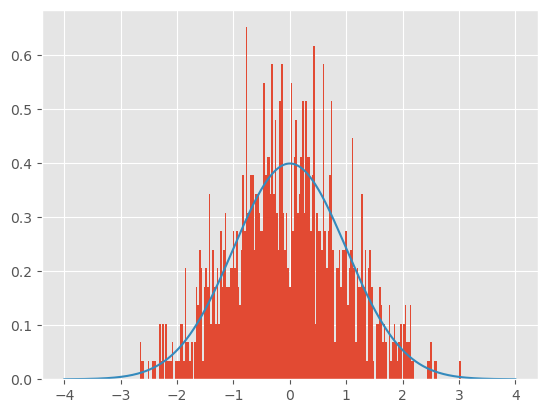

In [2]:
n = 10
epsilon = npr.standard_normal(2**n)
epsilon

epsilon = list(epsilon)
epsilon = pd.DataFrame(epsilon)

plt.hist(epsilon, bins = 200, density=True)
x = np.linspace(-4, 4, 1000)
plt.plot(x, 1 / np.sqrt(2 * np.pi) * np.exp(-x**2/2))
plt.show()

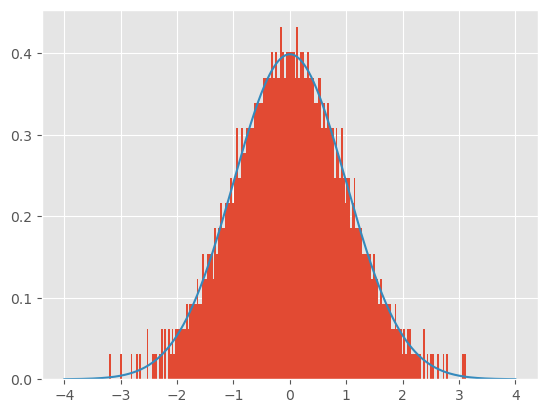

In [3]:
sobol = qmc.Sobol(d = 1, scramble = True)
epsilon = norm.ppf(sobol.random(2**10))

epsilon = list(epsilon)
epsilon = pd.DataFrame(epsilon)

plt.hist(epsilon, bins = 200, density=True)
x = np.linspace(-4, 4, 1000)
plt.plot(x, 1 / np.sqrt(2 * np.pi) * np.exp(-x**2/2))
plt.show()

In [4]:
def CallPriceBS(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + .5 * sigma**2) * T) \
    / (sigma * T**.5)
    d2 = d1 - sigma * T**.5
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    DF = np.exp(-r * T)
    price=S * n1 - K * DF * n2
    return price

In [5]:
def CallPriceBS_MC2(S, K, r, sigma, T, n):
    
    epsilon = npr.standard_normal(2**n)
    ST = S * np.exp(T * (r - 0.5 * sigma**2) \
                    + sigma * np.sqrt(T) * epsilon)
    
    payoff = np.maximum(ST - K ,0)
    
    payoff_avg = np.sum(payoff) / 2**n
    
    
    price = np.exp(-r * T) * payoff_avg
    
    return price


In [6]:
def CallPriceBS_QMC(S, K, r, sigma, T, n):
    #Sobol sequence
    sobol = qmc.Sobol(d = 1, scramble = True)
    #Generate QuasiMonte Carlo random numbers
    epsilon = norm.ppf(sobol.random(2**n))
    ST = S * np.exp(T * (r - 0.5 * sigma**2) \
                    + sigma * np.sqrt(T) * epsilon)
    
    payoff = np.maximum(ST - K ,0)
    
    payoff_avg = np.sum(payoff) / 2**n
    
    price = np.exp(-r * T) * payoff_avg
    
    return price

In [7]:
def EuropeanCallPrice_MC(s,k,r,stdev,T,N):
    
    #Define continuous-time stochastic process z, which follows a normal distribution N(0,t)
    z = npr.standard_normal(N)
    
    #Monte Carlo Simulation at date T for stock s done N times
    ST = s*np.exp(((r-0.5*stdev**2)*T)+stdev*np.sqrt(T)*z)
    
    #Payoff of Call
    payoff = np.maximum(ST-k,0)
    payoff_avg = np.sum(payoff)/N
    
    #use time discounting factor for PV 
    price = np.exp(-r*T)*payoff_avg 
    
    return price

In [8]:
#parameters
S = 100 #asset price
K = 110 #strike price
r = .05 #riskfree interest rate
sigma = .2 #asset volatility
T = .5 #time to maturity
n = 10 #number of simulations 2**n

CallPriceQMC = CallPriceBS_QMC(S, K, r, sigma, T, n)
CallPriceMC = CallPriceBS_MC2(S, K, r, sigma, T, n)
CallPrice = CallPriceBS(S, K, r, sigma, T)

print("Call Option Price: " + str(np.round(CallPrice,3)))
print("Call Option Price MC: " + str(np.round(CallPriceMC,3)))
print("Call Option Price QMC: " + str(np.round(CallPriceQMC,3)))

Call Option Price: 2.906
Call Option Price MC: 2.677
Call Option Price QMC: 2.902


## Variance Reduction Methods 

In [9]:
#####################
#Antithetic Variables

In [10]:
def CallPriceBS(S, K, r, sigma, T):
    d1 = (math.log(S / K) + (r + .5 * sigma**2) * T) / (sigma * T**.5)
    d2 = d1 - sigma * T**.5
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    DF = math.exp(-r * T)
    price=S * n1 - K * DF * n2
    return price

def PutPriceBS(S, K, r, sigma, T):
    d1 = (math.log(S / K) + (r + .5 * sigma**2) * T) / (sigma * T**.5)
    d2 = d1 - sigma * T**.5
    n1 = norm.cdf(-d1)
    n2 = norm.cdf(-d2)
    DF = math.exp(-r * T)
    price= K * DF * n2 - S * n1
    return price

In [11]:
#Estmation Call Price by Traditional Monte Carlo Simulation
def CallPriceBS_MC(S, K, r, sigma, T, N):
    
    z = npr.standard_normal(N)
    ST = S * np.exp(T * (r - 0.5 * sigma**2) + sigma * np.sqrt(T) * z)
    
    payoff = np.maximum(ST - K ,0)
    
    payoff_avg = np.sum(payoff) / N
    
    
    price = np.exp(-r * T) * payoff_avg
    
    return price


In [12]:
#Estimation Call Price by Antithetic Variates Monte Carlo
def CallPriceBS_MC_Antithetic(S, K, r, sigma, T, N):
    
    z = npr.standard_normal(N)
    ST = S * np.exp(T * (r - 0.5 * sigma**2) + sigma * np.sqrt(T) * z)
    
    ST_bis = S * np.exp(T * (r - 0.5 * sigma**2) + sigma * np.sqrt(T) * -z)
    
    payoff = np.maximum(ST - K ,0)

    payoff_bis = np.maximum(ST_bis - K ,0)
    
    payoff_avg = np.sum(payoff + payoff_bis) / (2*N)
    
    price = np.exp(-r * T) * payoff_avg
    
    return price

In [13]:
S0 = 100 #asset price
K = 110 #strike price
r = .05 #riskfree interest rate
sigma = .2 #asset volatility
T = .5 #time to maturity
N = 10000 #number of simulations
CallPriceMC = CallPriceBS_MC(S0, K, r, sigma, T, 2 * N)
CallPriceMCA = CallPriceBS_MC(S0, K, r, sigma, T, N)
CallPrice = CallPriceBS(S0, K, r, sigma, T)
print("Call Option Price: " + str(np.round(CallPrice,3)))
print("Call Option Price MC: " + str(np.round(CallPriceMC,3)))
print("Call Option Price MC Antithetic: " + str(np.round(CallPriceMCA,3)))

Call Option Price: 2.906
Call Option Price MC: 2.87
Call Option Price MC Antithetic: 3.006
